In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from LMPSTrajReader import Lammps_Traj
import networkx as nx
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [2]:
MSD_Filepath="MSD_Simulation"
MSD_Trajectory=Lammps_Traj(MSD_Filepath+"\\atom_disp_final.atom").getTraj()
data :pd.DataFrame=MSD_Trajectory[0]['Data']
np_data=data[['id','c_dispatom[1]','c_dispatom[2]','c_dispatom[4]']].to_numpy()
a=np_data[np_data[:, 0].argsort()] #Sorting by atom id
np.save(MSD_Filepath+"\\peratom_MSD_final.npy",a)


In [3]:
options = {
    "font_size": 6,
    #"node_size": 50,
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
    }
def draw_graph(G,axis,Nod_Color_data,vmax,vmin,xlim,ylim,node_size=50,cmap=plt.cm.bwr,Title="Title",cbar_title="Cbar_title"):
    ax_graph=axis
    pos=dict()
    for node in G:
        pos[node]=(G.nodes[node]['x'],G.nodes[node]['y'])
    nx.draw_networkx(G, pos=pos,node_color=Nod_Color_data,with_labels=False,ax=ax_graph,edgelist=[], cmap=cmap,vmax=vmax,vmin=vmin,node_size=node_size,**options)
    # Set margins for the axes so that nodes aren't clipped
    ax_graph.margins(0.20)
    ax_graph.set_xlim(xlim[0],xlim[1])
    ax_graph.set_ylim(ylim[0],ylim[1])
    ax_graph.set_title(Title)
    cbar=plt.colorbar(ScalarMappable(Normalize(vmin,vmax),cmap=cmap))
    cbar.set_label(cbar_title,weight='bold',rotation=270)


In [4]:
#-----------------Get_data_from graph----------------------#

G :nx.Graph=nx.read_graphml("19Norm.gml")
feat_data = []
node_map = {} # map node to Node_ID
i=1
for node in G:
    features=list(G.nodes[node].values())
    feat_data.append([float(x) for x in features])
    node_map[node] = i
    i+=1
feat_data = np.asarray(feat_data)
Attr=pd.DataFrame(feat_data)
#print(Attr)
pe=Attr[4]
type=Attr[0]
node_size=Attr[0]*100
#pe=ROC_Score
v_max=np.round(np.mean(pe)+2*np.std(pe),decimals=1)
v_min=np.round(np.mean(pe)-2*np.std(pe),decimals=1)
#fig,ax=plt.subplots(1,1,figsize=(10,8))
#draw_graph(G,ax,pe,v_max,v_min,(-1,21),(-1,21),Title="PE",cbar_title="P.E.",node_size=node_size)
# fig.savefig(Filepath+"_Atomicstructure.png")
node_pos_x=[]
node_pos_y=[]
for node in G:
    node_pos_x+=[G.nodes[node]['x']]
    node_pos_y+=[G.nodes[node]['y']]
Actual_PE_data :pd.DataFrame=pd.DataFrame({'x':node_pos_x,'y':node_pos_y,'pe':pe,'type':type})
#Actual_PE_data.to_csv("F:\Vaibhav\M3RG\Work\Binary_glass_loop_cool\Manuscript_prep\\4_Cluster_pe\Actual_pe.csv")
#plt.show()


#-----------------------------------------------------------#


In [5]:
#Finding MSD of clusters obtained from Graphsage 
#Clustering

#Read embeddings
Embs=pd.read_csv("Fin_embs_19.csv")
MSD_data=np.load(MSD_Filepath+"\\peratom_MSD_final.npy")

My_clust=OPTICS(metric='cosine',cluster_method='xi')
My_clust.fit(Embs)

order=My_clust.ordering_ 
labels=My_clust.labels_ 
reach=My_clust.reachability_[order]

In [17]:
#SORT LABELS INTO CLUSTERS----------------------
a=dict()
for i in range(len(labels)):
    if(labels[i] not in a):
        a[labels[i]]=[]
    a[labels[i]].append(i)

#ANALYSE CLUSTERS-------------------------------
size_clust=[]
MSD_cluster=[]
avg_pe_clust=[]
avg_pe_clust_err=[]
msd=[]
clust_color=[0 for i in range(500)]
pe_color=[0 for i in range(500)]
MSD_color=[0 for i in range(500)]
for i in a.keys():
    size_clust+=[len(a[i])]
    nodeList=[]
    pe=[]
    pos=dict()
    clust_atom_list=[l for l in a[i]]
    clust_MSD=np.average(MSD_data[[clust_atom_list]],axis=0)[3]
    MSD_cluster+=[clust_MSD]
    print("\nCluster No. : ",i," Mean MSD: ",clust_MSD)
    for k in a[i]:
        pe+=[Attr[4][k]]
        nodeList+=[str(k+1)]
        clust_color[k]=[i]
        msd+=[MSD_data[k][3]]
    for k in a[i]:
        if(i==-1):
            pe_color[k]=-10
            MSD_color[k]=-20        
        else:
            pe_color[k]=np.mean(pe)
            MSD_color[k]=clust_MSD
    avg_pe_clust+=[np.mean(pe)]
    avg_pe_clust_err+=[np.std(pe)]    
    msd_analysis_data: pd.DataFrame=pd.DataFrame({"MSD_cluster":MSD_cluster})
    msd_analysis_data.to_csv("CLuster_MSD.csv")
                



Cluster No. :  0  Mean MSD:  0.6711372142857144

Cluster No. :  -1  Mean MSD:  0.7896604666666671

Cluster No. :  8  Mean MSD:  0.7110268666666669

Cluster No. :  1  Mean MSD:  0.5624167272727273

Cluster No. :  10  Mean MSD:  0.864001

Cluster No. :  14  Mean MSD:  0.64974

Cluster No. :  15  Mean MSD:  0.8870873333333333

Cluster No. :  6  Mean MSD:  0.6822764761904763

Cluster No. :  13  Mean MSD:  0.6629216

Cluster No. :  5  Mean MSD:  0.9751592

Cluster No. :  11  Mean MSD:  0.9705532

Cluster No. :  12  Mean MSD:  0.6908928

Cluster No. :  7  Mean MSD:  0.8956711666666667

Cluster No. :  9  Mean MSD:  0.6877893399999999

Cluster No. :  4  Mean MSD:  0.5327901666666667

Cluster No. :  2  Mean MSD:  0.9449205000000002

Cluster No. :  3  Mean MSD:  1.0383289999999998


C:\Users\DIKSHIKA\AppData\Local\Temp\ipykernel_33648\3225595438.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clust_MSD=np.average(MSD_data[[clust_atom_list]],axis=0)[3]


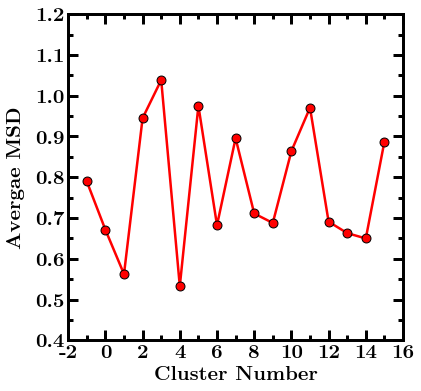

In [10]:
import matplotlib
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from networkx.readwrite import edgelist
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,FormatStrFormatter,AutoMinorLocator)

#MSD plot
fig1,ax1 =plt.subplots(1,1,figsize=(6,6))
mycmap=plt.cm.tab20
plt.rcParams['axes.linewidth']=2.5
plt.rcParams["font.family"]='CMU serif'
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size']=25
x=np.zeros((len(a.keys()),1))
y=np.zeros((len(a.keys()),1))
for (p,q) in list(zip(list(a.keys()),MSD_cluster)):
    x[p+1]=p
    y[p+1]=q

#ax1.scatter(x,y,s=5)#c=labels[order],cmap=mycmap,norm=Normalize(-1,20),linewidths=2)
#ax1.plot(x,y)#c=labels[order],cmap=mycmap,norm=Normalize(-1,20),linewidths=2)
ax1.plot(x,y,linewidth=2.5,color='r')#,zorder=1)
ax1.scatter(list(a.keys()),MSD_cluster,s=80,edgecolors='k',linewidths=1,color='r',zorder=2)
    

ax1.set_xlabel("Cluster Number",fontsize=20,fontweight='bold')
ax1.set_ylabel("Avergae MSD",labelpad=10.0,fontsize=20,fontweight='bold')

ax1.tick_params(width=3,direction='in',length=10,labelsize=20)
ax1.set_ylim(0.4,1.2)
ax1.set_xlim(-2,16)
ax1.tick_params(which='minor',width=3,direction='in',length=5,labelsize=20)
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_major_locator(MultipleLocator(0.1))
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1_y=ax1.twinx()
ax1_x=ax1.twiny()
ax1_y.set_ylim(0.4,1.2)
ax1_x.set_xlim(-2,16)
ax1_y.yaxis.set_major_locator(MultipleLocator(0.1))
ax1_x.xaxis.set_major_locator(MultipleLocator(2))
ax1_y.minorticks_on()
ax1_x.minorticks_on()
ax1_x.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1_y.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1_y.tick_params(which='minor',width=3,direction='in',length=5,labelright=False)
ax1_x.tick_params(which='minor',width=3,direction='in',length=5,labelright=False)
ax1_y.tick_params(width=3,direction='in',length=10,labelright=False)
ax1_x.tick_params(width=3,direction='in',length=10,labeltop=False)

ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

#fig1.savefig("Reachability_plot.png",dpi=900,quality=95,bbox_inches=matplotlib.transforms.Bbox([[0, 0], [10, 8]]))
plt.show()



C:\Users\DIKSHIKA\AppData\Local\Temp\ipykernel_33648\2025771788.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  mycmap.set_under("lightgray")
C:\Users\DIKSHIKA\AppData\Local\Temp\ipykernel_33648\2025771788.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  mycmap.set_over("lightgray")


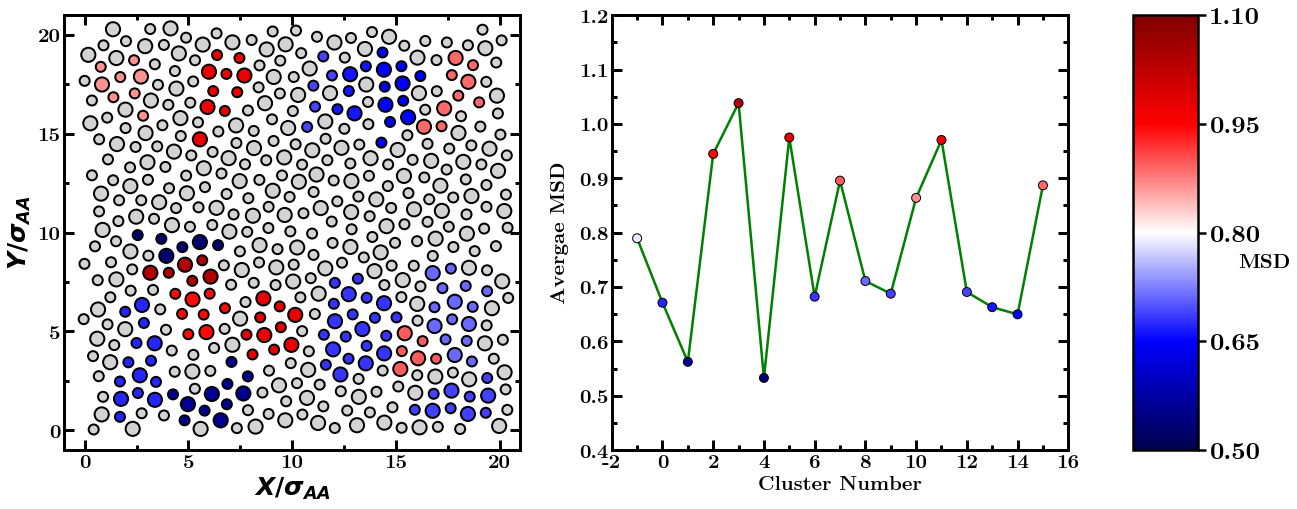

In [15]:
v_min=np.round(np.mean(MSD_cluster)-2*np.std(MSD_cluster),decimals=1)
v_max=np.round(np.mean(MSD_cluster)+2*np.std(MSD_cluster),decimals=1)
from matplotlib.ticker import AutoMinorLocator
fig,(ax,ax1) =plt.subplots(1,2,figsize=(18,8))
mycmap=plt.cm.seismic
#mycmap=plt.cm.tab20
mycmap.set_under("lightgray")
mycmap.set_over("lightgray")
#ax.scatter(node_pos_x,node_pos_y,s=node_size,c=pe_color,cmap=mycmap,norm=Normalize(v_min,v_max),edgecolors='k',linewidths=2)
ax.scatter(node_pos_x,node_pos_y,s=node_size,c=MSD_color,cmap=mycmap,norm=Normalize(v_min,v_max),edgecolors='k',linewidths=2)

ax.tick_params(width=3,direction='in',length=10,labelsize=20)
ax.set_ylim(-1,21)
ax.set_xlim(-1,21)
ax.tick_params(which='minor',width=3,direction='in',length=5,labelsize=20)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.set_xticks(ticks=[0,5,10,15,20])
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

#ax.set_min
ax.set_yticks(ticks=[0,5,10,15,20])
ax.set_xticklabels(labels=['0','5','10','15','20'],fontname='CMU Serif',fontsize=20,fontweight='bold')
ax.set_yticklabels(labels=['0','5','10','15','20'],fontname='CMU Serif',fontsize=20,fontweight='bold')
a2=ax.twinx()
a3=ax.twiny()
a2.set_ylim(-1,21)
a3.set_xlim(-1,21)
a2.yaxis.set_major_locator(MultipleLocator(5))
a3.xaxis.set_major_locator(MultipleLocator(5))
a2.minorticks_on()
a3.minorticks_on()
a2.xaxis.set_minor_locator(AutoMinorLocator(2))
a2.yaxis.set_minor_locator(AutoMinorLocator(2))
a3.xaxis.set_minor_locator(AutoMinorLocator(2))
a3.yaxis.set_minor_locator(AutoMinorLocator(2))

a2.tick_params(which='minor',width=3,direction='in',length=5,labelright=False)
a3.tick_params(which='minor',width=3,direction='in',length=5,labelright=False)
a2.tick_params(width=3,direction='in',length=10,labelright=False)
a3.tick_params(width=3,direction='in',length=10,labeltop=False)
ax.set_xlabel(r'$X/\sigma_{AA}$',fontname='CMU Serif',fontsize=25,fontweight='bold')
ax.set_ylabel(r'$Y/\sigma_{AA}$',fontname='CMU Serif',fontsize=25,fontweight='bold')
cax = plt.axes([0.95,0.125,0.05,0.755])
cbar=plt.colorbar(ScalarMappable(Normalize(v_min,v_max),cmap=mycmap),cax=cax)
cbar.set_label("     \nMSD",weight='bold',rotation=360,fontsize=20)

cbar.set_ticks(ticks=np.linspace(v_min,v_max,5))
cbar.ax.tick_params (size=8, width =2.5)
##F:\Vaibhav\M3RG\Work\Binary_glass_loop_cool\Manuscript_prep
#ax.set_title(r"$(b)$",loc='left',fontsize=20)
#fig.savefig("F:\Vaibhav\M3RG\Work\Binary_glass_loop_cool\Manuscript_prep\\4_Cluster_pe\clust_pe.png",dpi=900,quality=95,bbox_inches=matplotlib.transforms.Bbox([[0, 0], [10, 8]]))




mycmap=plt.cm.seismic
v_min=np.round(np.mean(MSD_cluster)-2*np.std(MSD_cluster),decimals=1)
v_max=np.round(np.mean(MSD_cluster)+2*np.std(MSD_cluster),decimals=1)

x=np.zeros((len(a.keys()),1))
y=np.zeros((len(a.keys()),1))
for (p,q) in list(zip(list(a.keys()),MSD_cluster)):
    x[p+1]=p
    y[p+1]=q

#ax1.scatter(x,y,s=5)#c=labels[order],cmap=mycmap,norm=Normalize(-1,20),linewidths=2)
#ax1.plot(x,y)#c=labels[order],cmap=mycmap,norm=Normalize(-1,20),linewidths=2)
ax1.plot(x,y,linewidth=2.5,color='g')#,zorder=1)
ax1.scatter(list(a.keys()),MSD_cluster,c=MSD_cluster,s=80,edgecolors='k',linewidths=1,zorder=2,cmap=mycmap,norm=Normalize(v_min,v_max))
    

ax1.set_xlabel("Cluster Number",fontsize=20,fontweight='bold')
ax1.set_ylabel("Avergae MSD",labelpad=10.0,fontsize=20,fontweight='bold')

ax1.tick_params(width=3,direction='in',length=10,labelsize=20)
ax1.set_ylim(0.4,1.2)
ax1.set_xlim(-2,16)
ax1.tick_params(which='minor',width=3,direction='in',length=5,labelsize=20)
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_major_locator(MultipleLocator(0.1))
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1_y=ax1.twinx()
ax1_x=ax1.twiny()
ax1_y.set_ylim(0.4,1.2)
ax1_x.set_xlim(-2,16)
ax1_y.yaxis.set_major_locator(MultipleLocator(0.1))
ax1_x.xaxis.set_major_locator(MultipleLocator(2))
ax1_y.minorticks_on()
ax1_x.minorticks_on()
ax1_x.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1_y.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1_y.tick_params(which='minor',width=3,direction='in',length=5,labelright=False)
ax1_x.tick_params(which='minor',width=3,direction='in',length=5,labelright=False)
ax1_y.tick_params(width=3,direction='in',length=10,labelright=False)
ax1_x.tick_params(width=3,direction='in',length=10,labeltop=False)

ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

#fig1.savefig("Reachability_plot.png",dpi=900,quality=95,bbox_inches=matplotlib.transforms.Bbox([[0, 0], [10, 8]]))
plt.show()

